<a href="https://colab.research.google.com/github/momova97/EAI6010/blob/main/EAI6010_MohammadMovahedi_Week2_FallB_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EAI6010 - Module 2: AI Learning Concepts. Distributed AI Applications
By Mohammad Movahedi

## Introduction
Neural artistic style transfer is an interesting area that lies at the point of overlap between art and technology; it involves applying deep learning techniques to move the stylistics of one picture into the content of another. A new style transfer model based on Tensorflow has been implemented in Google Colab for this report to assess its efficacy. It shows impressive results from neural networks by combining the selected image with another’s artistic style. We examine and utilize these techniques, evaluate them for efficiency, and investigate their art possibilities (Instructure.com, 2020).

## Analysis
In the main part, we look at a real world usage case for the neural style transfer algorithm. First, we repeat an ordinary case - the "Golden Gate Bridge" to realize the basic functions of the script. The experiment is then extended by adding two unique images: As for the content image, I choose the portrait, while for style reference I select the logo of Northeastern University. The analysis provides a thorough description of each step involved in the process, starting from setting up the Google Colab environment with GPU acceleration to performing style transfer. Outcomes are shown graphically reflecting how the stylistic elements of the stylus image were applied on the content image. Taking it further would be adding a new content image in the same style as one’s favorite artist thus showing how flexible and creative the algorithm can be (Instructure.com, 2020).

##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

### Fast Style Transfer for Arbitrary Styles


Based on the model code in [magenta](https://github.com/tensorflow/magenta/tree/master/magenta/models/arbitrary_image_stylization) and the publication:

[Exploring the structure of a real-time, arbitrary neural artistic stylization
network](https://arxiv.org/abs/1705.06830).
*Golnaz Ghiasi, Honglak Lee,
Manjunath Kudlur, Vincent Dumoulin, Jonathon Shlens*,
Proceedings of the British Machine Vision Conference (BMVC), 2017.

== Additions and modifications by Vladimir Shapiro


### Setup

Let's start with importing TF-2 and all relevant dependencies.

This script imports necessary libraries and modules for image processing and machine learning, including TensorFlow and TensorFlow Hub. It then prints the versions of TensorFlow and TensorFlow Hub, checks if TensorFlow is running in eager execution mode, and verifies if a GPU is available for computation.

In [2]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF Version:  2.14.0
TF-Hub version:  0.15.0
Eager mode enabled:  True
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Below script defines functions for loading, processing, and visualizing images in Python using TensorFlow. It includes functions to crop images to a square, load and preprocess images from a URL or local bytes, and display multiple images with titles in a row. The load_image function handles image caching, normalization, and resizing, while show_n is used for displaying images using Matplotlib. load_local_image allows for loading and preprocessing images from local byte data.

In [3]:
# @title Define image loading and visualization functions  { display-mode: "form" }

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

def load_local_image(image_bytes, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
   # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = image_bytes
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img


### Import TF-Hub module
This script loads a TensorFlow Hub module specifically for arbitrary image stylization. It sets the URL for the module, which is hosted on TensorFlow Hub, and then uses TensorFlow Hub's load function to load the module for use in image stylization tasks.

In [4]:
# Load TF-Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

First, try the original (from the Tensorflow source) files:

This script sets up the process of neural style transfer by loading example content and style images from specified URLs. It defines the size for the output image and adjusts the sizes for the content and style images to match the model's requirements. The content image can be of any size, but the style image is recommended to be 256x256 for optimal results. The load_image function is used to load and preprocess both images, and an additional average pooling operation is applied to the style image. Finally, the script displays both the content and style images using the previously defined show_n function.

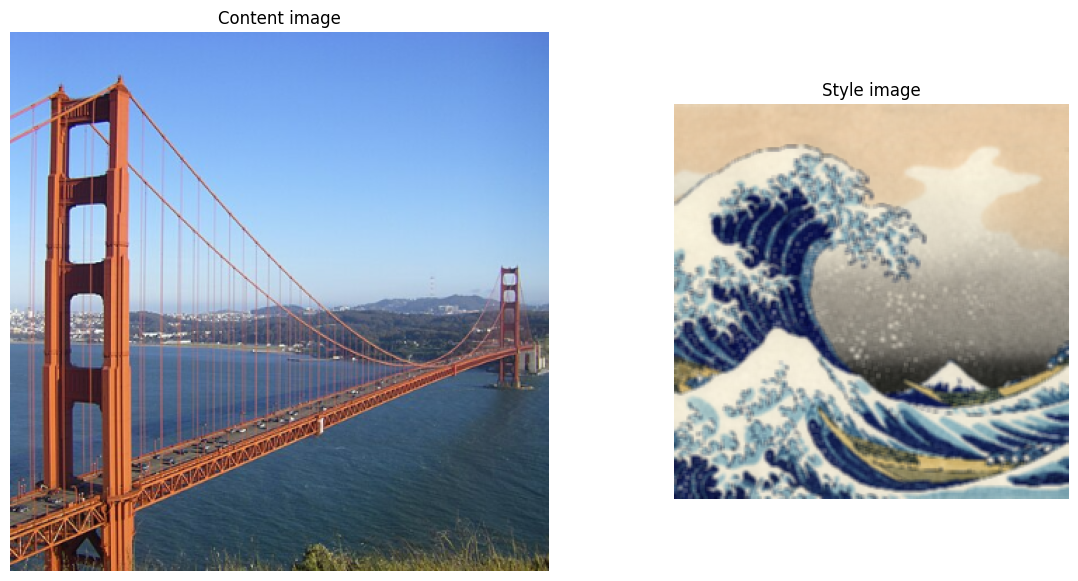

In [11]:
# @title Load example images  { display-mode: "form" }

content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the
# recommended image size for the style image (though, other sizes work as
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

## Demonstrate image stylization

The signature of this hub module for image stylization is:
```
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]
```
Where `content_image`, `style_image`, and `stylized_image` are expected to be 4-D Tensors with shapes `[batch_size, image_height, image_width, 3]`.

In the current example we provide only single images and therefore the batch dimension is 1, but one can use the same module to process more images at the same time.

The input and output values of the images should be in the range [0, 1].

The shapes of content and style image don't have to match. Output image shape
is the same as the content image shape.

## Calculate and Display

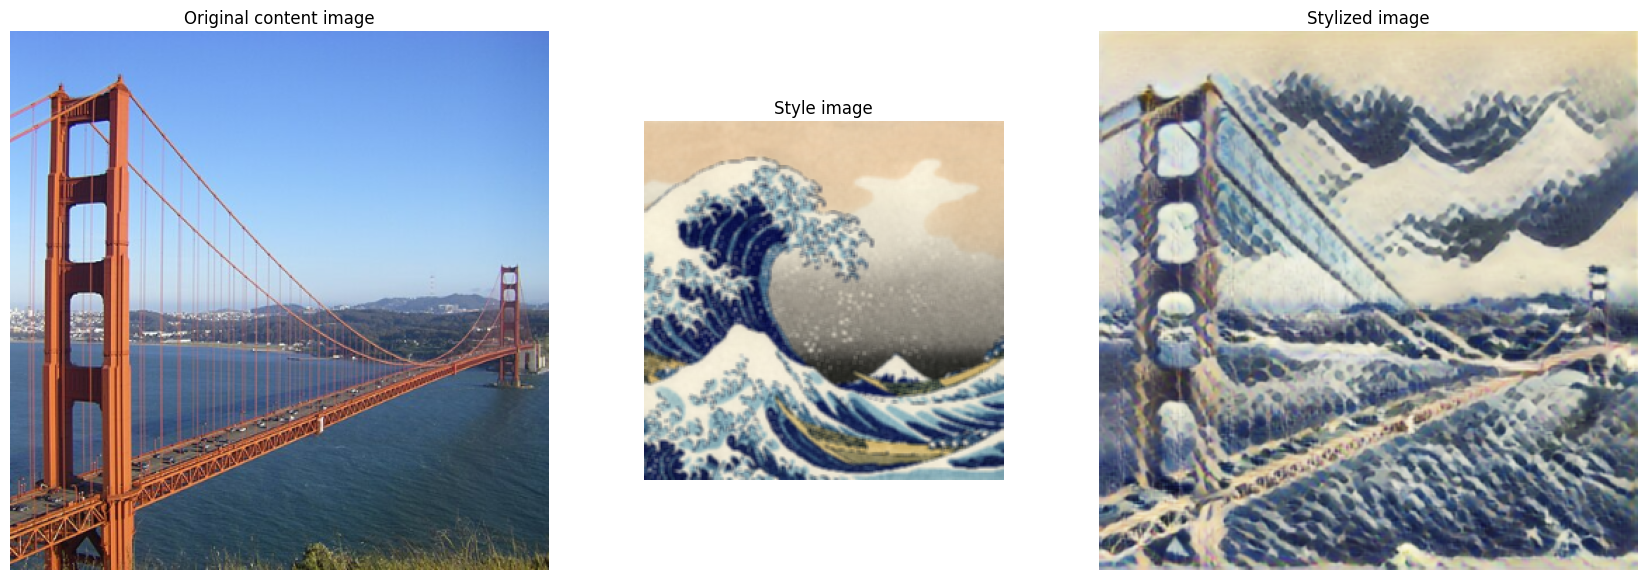

In [12]:
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

### Other examples

This script enables the user to upload their own content and style images from the local filesystem, using Google Colab's file upload feature. After the images are uploaded, the script reads them into numpy arrays and preprocesses them to the appropriate sizes for the neural style transfer model. The model, loaded from TensorFlow Hub, is then used to apply the style of the uploaded style image to the uploaded content image, creating a stylized version of the content image. Finally, it visualizes the original content image, the style image, and the generated stylized image side by side.

Browse to the style file  to be uploaded


Saving Hudsons-Bay-Company-300x232.jpg to Hudsons-Bay-Company-300x232.jpg
User uploaded file Hudsons-Bay-Company-300x232.jpg with length 14819 fbytes
Browse to the content file to be uploaded


Saving wallpapersden.com_tom-cruise-4k-top-gun-maverick_3840x5760.jpg to wallpapersden.com_tom-cruise-4k-top-gun-maverick_3840x5760 (1).jpg
User uploaded content file wallpapersden.com_tom-cruise-4k-top-gun-maverick_3840x5760 (1).jpg with length 9527769 fbytes


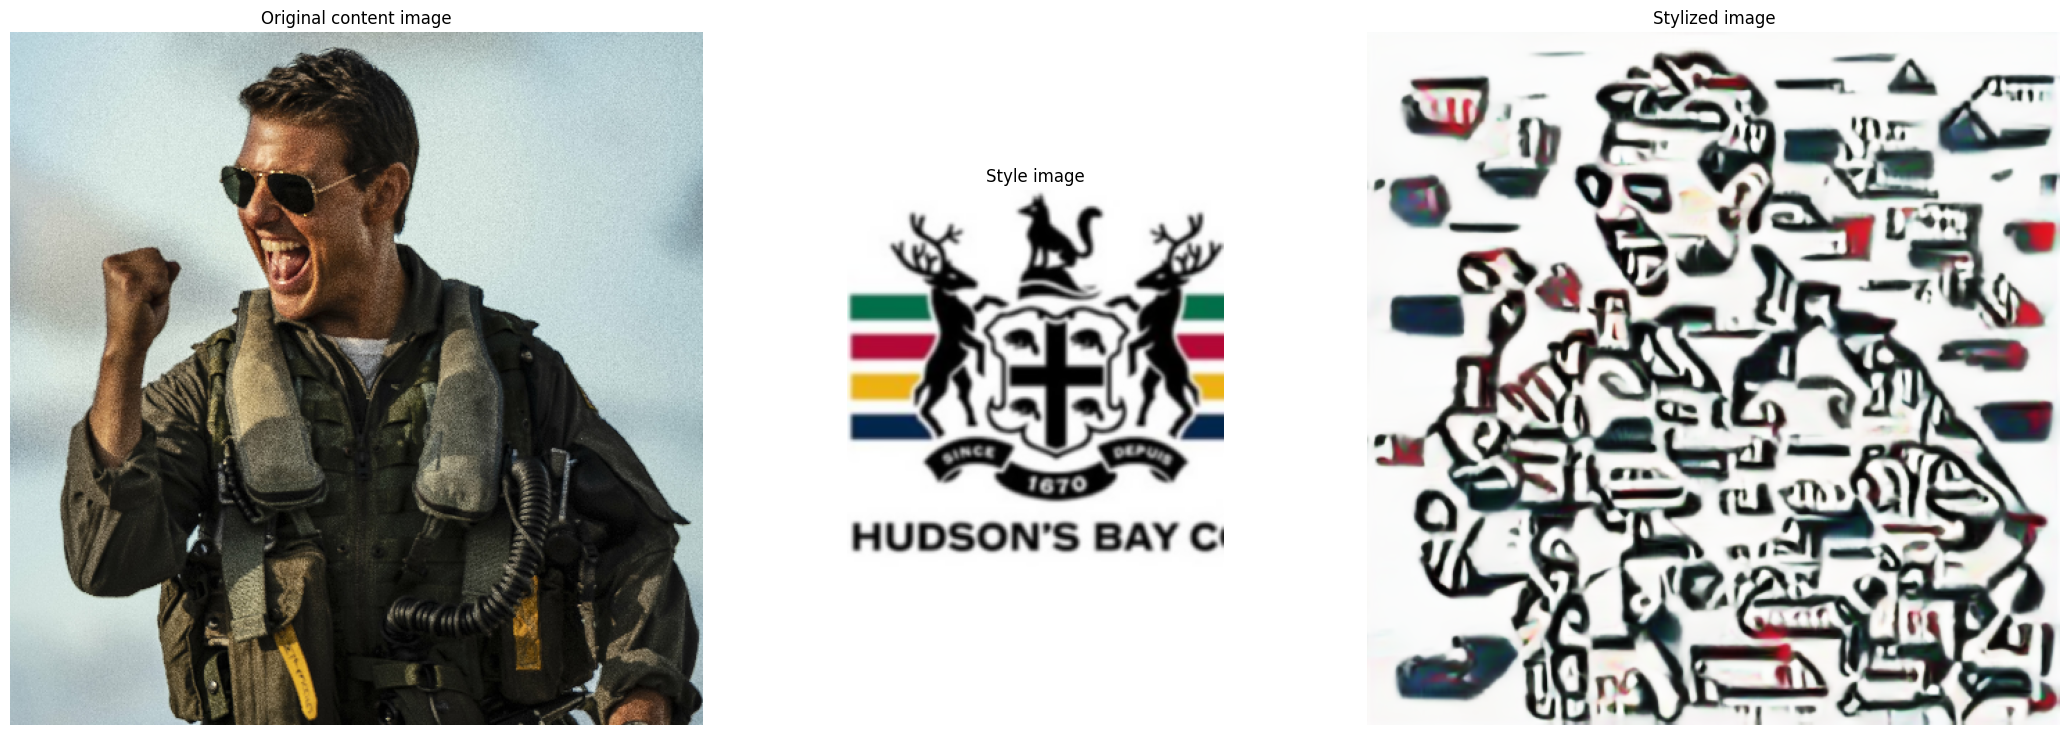

In [14]:
from google.colab import files
# load style image from the local filesystem
print("Browse to the style file  to be uploaded")
style_uploaded = files.upload()
for fn in style_uploaded.keys():
  print("User uploaded file {name} with length {length} fbytes".format(name=fn,
                                                      length=len(style_uploaded[fn])))
style_img = plt.imread(fn).astype(np.float32)[np.newaxis, ...]

# load content image from the local filesystem
print("Browse to the content file to be uploaded")
content_uploaded = files.upload()
for fn in content_uploaded.keys():
  print("User uploaded content file {name} with length {length} fbytes".format(name=fn,
                                                      length=len(content_uploaded[fn])))
content_img = plt.imread(fn).astype(np.float32)[np.newaxis, ...]

# @title Load example images  { display-mode: "form" }
output_image_size = 500  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the
# recommended image size for the style image (though, other sizes work as
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_local_image(content_img, content_img_size) #load_image(content_image_url, content_img_size)
style_image = load_local_image(style_img, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
#show_n([content_image, style_image], ['Content image', 'Style image'])

# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

# Visualize input images and the generated stylized image.
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

# Conclusion
In conclusion, I highlighted the key learnings as well as outcomes of the conducted research experiments. Neural style transfer as a method for photo manipulation and artistic means, which possesses strong ability to impose art on another kind of pictures reviewed. Stylistic changes make a significant difference in the last image, proving the sensitivity of this algorithm to style specifics. Secondly, the experiment sheds light on the value of computer resources since it necessitated GPU acceleration in order to accomplish effective processing. The result of this assignment shows future study directions, particularly on enhancing the algorithm ability to detect and reproduce subtle art shapes.

# References
Instructure.com. (2020). Assignment_Week_2. [online] Available at: https://northeastern.instructure.com/courses/160651/assignments/2035947#submit [Accessed 12 Nov. 2023].

‌
Golnaz, Ghiasi, et al. Exploring the Structure of a Real-Time, Arbitrary Neural Artistic Stylization Network. 28 Aug. 2017.